In [1]:
import time
from typing import Tuple, List, Set
from networkx import clustering

import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from networkx import erdos_renyi_graph
from scipy.optimize import curve_fit
import requests

In [2]:
FONT_SIZE = 16
RANDOM_SEED = 42
matplotlib.rcParams.update({'font.size': FONT_SIZE})

In [3]:
G = nx.read_edgelist("graph.txt")

In [4]:
print("Число вершин:", G.number_of_nodes())
print("Число рёбер:", G.number_of_edges())

Число вершин: 875713
Число рёбер: 4322051


In [6]:
len(G.nodes())

875713

In [7]:
degrees = defaultdict(int)  # {Степень : Число вершин}

for v in G.nodes():
    deg = G.degree(v)
    degrees[deg] += 1

In [8]:
x = sorted(degrees.keys())
y = [degrees[deg] for deg in x]

In [9]:
cumulative_distribution = defaultdict(int)
s = 0
for deg in sorted(degrees.keys(), reverse=True):
    s += degrees[deg]
    cumulative_distribution[deg] = s

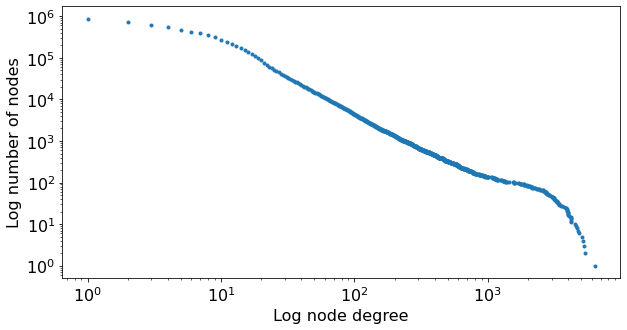

In [10]:
x = sorted(cumulative_distribution.keys())
y = [cumulative_distribution[d] for d in x]

plt.figure(figsize=(10, 5), )
plt.loglog(x, y, ls='None', marker='.')
plt.xlabel("Log node degree", )
plt.ylabel("Log number of nodes")
plt.show()

In [11]:
def func(d, c, gamma):
    return c / np.power(d, gamma)

In [12]:
degree_distrib_offset = 0.015
num_samples = len(x)

optimized_x = x[int(num_samples * degree_distrib_offset): int(num_samples - num_samples * degree_distrib_offset)]
optimized_y = y[int(num_samples * degree_distrib_offset): int(num_samples - num_samples * degree_distrib_offset)]
popt, pcov = curve_fit(func, optimized_x, optimized_y)

In [13]:
popt

array([2.70338192e+07, 1.91960289e+00])

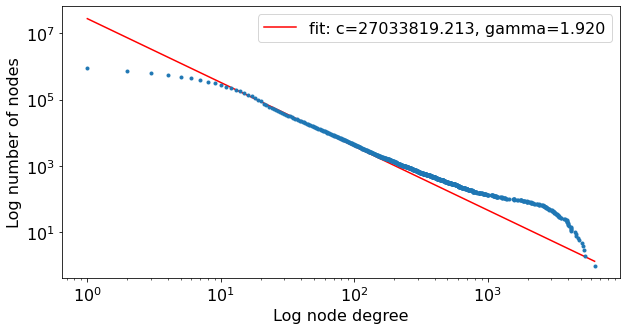

In [14]:

plt.figure(figsize=(10, 5), )
plt.loglog(x, func(x, *popt), 'r-', label='fit: c=%5.3f, gamma=%5.3f' % tuple(popt))
plt.loglog(x, y, ls='None', marker='.')
plt.xlabel("Log node degree", )
plt.ylabel("Log number of nodes")
plt.legend()
plt.show()

# Задача 8

In [15]:
n = 300
x = np.arange(0., 1.05, 0.05)


In [16]:
def jaccard_index(set_a, set_b):
    set_a = set(set_a)
    set_b = set(set_b)
    intersection = set_a.intersection(set_b)
    union = set_a.union(set_b)
    return len(intersection) / len(union)


def edge_jaccard(graph: nx.Graph, edge: Tuple[int, int]):
    (u, v) = edge
    u_neighbors = graph.neighbors(u)
    v_neighbors = graph.neighbors(v)
    return jaccard_index(u_neighbors, v_neighbors)


def mean_graph_jaccard(graph: nx.Graph, ):
    num_edges = graph.number_of_edges()
    s = 0
    for edge in graph.edges:
        jac_value = edge_jaccard(graph=graph, edge=edge)
        s += jac_value
    if num_edges > 0:
        return s / num_edges
    else:
        return 0.

In [17]:
empirical_jaccard_values_list = []
for p in x:
    G_erdos_renyi = erdos_renyi_graph(n=n, p=p, seed=RANDOM_SEED)
    jac_val = mean_graph_jaccard(G_erdos_renyi)
    empirical_jaccard_values_list.append(jac_val)
theoretical_jaccard_values_list = [p * p / (1 - (1 - p) * (1 - p)) if p > 0 else 0 for p in x]

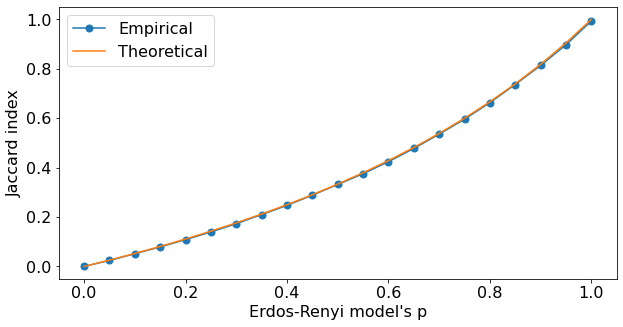

In [34]:
plt.figure(figsize=(10, 5), )
plt.plot(x, empirical_jaccard_values_list, marker='.', label="Empirical", markersize=14)
plt.plot(x, theoretical_jaccard_values_list, label="Theoretical")
plt.xlabel("Erdos-Renyi model's p", )
plt.ylabel("Jaccard index")
plt.legend()
plt.show()

# Задача 9

In [19]:
FRIENDS_URL_PATTERN = "http://www.livejournal.com/misc/fdata.bml?user=<username>"
INITIAL_USERNAME = "oh-rid"


In [27]:
def recursive_traverse_friends(initial_username: str, edges: Set[str], keep_usernames: Set[str], depth: int):
    initial_url = FRIENDS_URL_PATTERN.replace("<username>", initial_username)
    time.sleep(1.0)
    response = requests.get(initial_url)
    friends_list = response.text.split('\n')
    for line in friends_list:
        edge = None
        username = None
        if line.startswith('>'):
            username = line[1:].strip()
            keep_usernames.add(username)
            assert "~~~~~~~~~~" not in initial_username
            assert "~~~~~~~~~~" not in username
            edge = f"{initial_username}~~~~~~~~~~{username}"
        else:
            continue
        if edge is not None:
            edges.add(edge)
        if username is not None and depth > 0:
            recursive_traverse_friends(initial_username=username, edges=edges, keep_usernames=keep_usernames,
                                       depth=depth - 1)


def save_edges(edges: List[Tuple[int, int]], save_path):
    with open(save_path, 'w+', encoding="utf-8") as output_file:
        for (source_node, dest_node) in edges:
            output_file.write(f"{source_node}\t{dest_node}\n")

In [28]:
edges = set()
keep_usernames = {INITIAL_USERNAME}
recursive_traverse_friends(initial_username=INITIAL_USERNAME, edges=edges, keep_usernames=keep_usernames, depth=1)
edges = [(t.split('~~~~~~~~~~')[0], t.split('~~~~~~~~~~')[1]) for t in edges]

In [29]:
save_edges(edges=edges, save_path="task_9_edges.tsv")

In [30]:
G = nx.Graph()
for (source, dest) in edges:
    G.add_edge(source, dest)

# локальный кластерный коэффициент

In [ ]:
clustering(G, INITIAL_USERNAME)